# Chapter 3 분류
# 3.1 MNIST

In [1]:
# MNIST 데이터셋 내려받기 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

/Users/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어들인 데이터셋의 구조 : 일반적으로 딕셔너리 구조
* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
* 레이블 배열을 담은 target 키

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

# 이미지가 7만개 존재하고 각 이미지에는 784개의 특성이 존재한다. (이미지가 28*28 픽셀이기 때문이다)

(70000, 784)
(70000,)


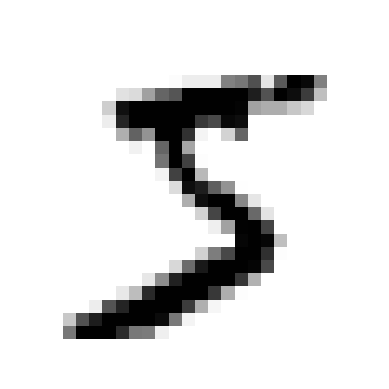

In [3]:
# 데이터셋에서 이미지 하나 확인해보기.
# 샘플의 특성 벡터를 추출해 28*28 배열로 크기를 바꾸고 맷플롯립의 imshow() 함수를 사용해 그린다
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
# 실제 레이블 확인해보기
y[0]

'5'

In [5]:
# 레이블이 문자열이므로 y를 정수로 반환하기.
import numpy as np
y = y.astype(np.uint8)

In [6]:
# 그림 그리는 기능을 함수로 만들어두자.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

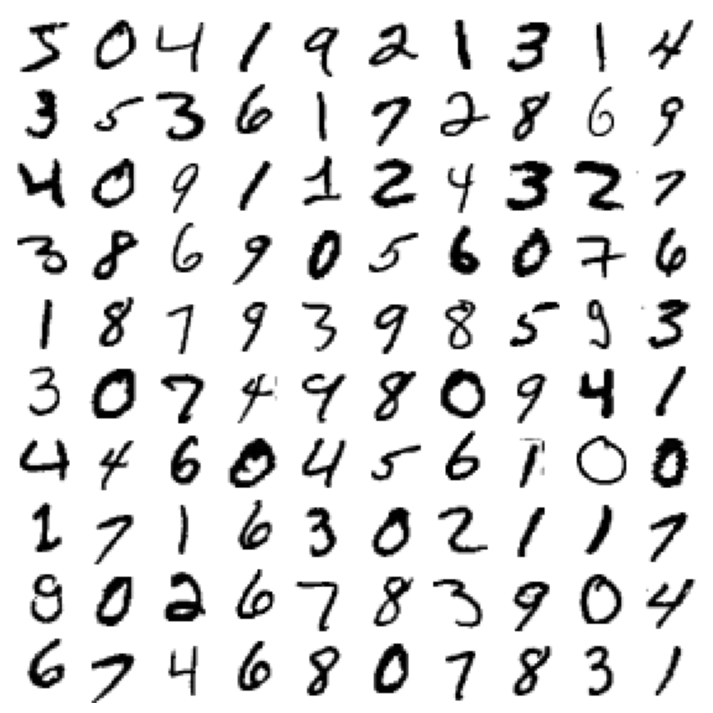

In [7]:
plt.figure(figsize=(9,9))
example_images = X[:100] # 100개만 출력
plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
# 테스트세트 떼어놓기
# MNIST 데이터셋은 이미 훈련세트로 나누어져있음 (6만개)

X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]



# 3.2 이진 분류기 훈련
Ex) 숫자5만 식별하는 분류기를 예시로 생각해보자.

In [9]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(
    max_iter=1000, # 최대 반복횟수를 지정, 원래 기본값이 1000
    tol=1e-3, # tolerance값보다 모델이 향상되지 않으면 훈련을 멈추라는 종료 장치
    random_state=42)
# 위의 변수들이 다 default이기 때문에 
# SGDClassifier(random_state=42)랑 똑같다.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])
# 예측 결과가 맞음.

array([ True])

# 3.3 성능 측정
분류기 평가는 회귀모델보다 어렵다. 사용할 수 있는 성능 지표가 많다.

## 3.3.1 교차 검증을 사용한 정확도 측정

In [12]:
# 교차 검증 구현
# 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 때
# 교차 검증 기능을 직접 구현

'''from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import clone

skfolds = StratifiedGroupKFold(n_splits=3,random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))'''

'from sklearn.model_selection import StratifiedGroupKFold\nfrom sklearn.base import clone\n\nskfolds = StratifiedGroupKFold(n_splits=3,random_state=42, shuffle=True)\n\nfor train_index, test_index in skfolds.split(X_train,y_train_5):\n    clone_clf = clone(sgd_clf)\n    X_train_folds = X_train[train_index]\n    y_train_folds = y_train_5[train_index]\n    X_test_fold = X_train[test_index]\n    y_test_fold = y_train_5[test_index]\n\n    clone_clf.fit(X_train_folds, y_train_folds)\n    y_pred = clone_clf.predict(X_test_fold)\n    n_correct = sum(y_pred == y_test_fold)\n    print(n_correct / len(y_pred))'

In [13]:
# cross_val_score() 함수로 폴드가 3개인  k겹 교차검증을 사용

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# 주어진 모든 이미지를 "5 아님" 으로 분류하는 더미분류기를 만들어 비교해보자.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
# 모델의 정확도 추측하기

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# 정확도가 90프로이상 나온 이유는 전체 이미지 중 5가 10퍼센트 정도 되기때문.
# '정확도' 를 분류기의 성능 측정 지표로 선호하지 않는 이유이다. 특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차행렬
분류기의 성능 평가 시 오차행렬(confusion matrix) 를 조사하는 방법이 있다.

클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 방식.

숫자5의 이미지를 3으로 잘못 분류한 횟수를 알고싶다면 오차행렬의 5행3열을 보면 된다.

In [15]:
# 오차 행렬을 만드려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야한다.
# 테스트 세트는 사용하면 안됨.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# cross_val_predict() 함수는 cross_val_score 처럼 k-fold 교차검증을 수행하지만 , 평가 점수가 아닌 각 테스트폴드에서 얻은 예측을 반환한다.
# 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻음

In [16]:
# confusion_matrix() 함수를 사용해 오차 행렬을 만들어보자.
# 타깃 클래스 y_train_5 와 y_train_pred 를 넣고 호출

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#  TN  FP
#  FN  TP

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)  # 대각원소만 0이 아니게된다 (정확히 예측하기때문)

array([[54579,     0],
       [    0,  5421]])

* 정밀도와 재현율

 1. 정밀도: 맞다고 예측한것 중 실제 맞는것의 비율
 2. 재현율(민감도) : 실제 맞는것들 중 정확히 예측한 비율

## 3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))   # 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred))     # 3530 / (1891 + 3530)

# 이 분류기의 정확도 : 0.838
# 재현율(민감도) : 0.651

0.8370879772350012
0.6511713705958311


* F1 score

정밀도와 재현율을 F1 score 라고 하는 하나의 숫자로 만들면 편리하다.

F1 score 는 정밀도와 재현율의 조화평균이다.(역수의 평균의 역수)

F1 score 를 계산하려면 f1_score() 함수를 호출하면 된다.


In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

* 점수에 대하여

정밀도와 재현율이 비슷한 분류기에서는 F1 score가 높게나온다.

하지만 상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있다.

정밀도와 재현율은 반비례 관계인데, 이를 정밀도/재현율 트레이드오프 라고한다.

## 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier 가 분류를 어떻게 결정하는지 살펴보며 이를 이해해보자.

이 분류기는 결정함수(decision function) 를 사용한다
* 결정함수
 1. 각 샘플의 점수를 계산한다.
 2. 계산한 점수를 임곗값과 비교해 크면 양성, 작으면 음성 클래스에 할당한다.
 3. 보통 임곗값이 높아질수록 정확도가 높아지고, 반대의 경우 재현율이 높아진다.

사이킷런에서 임곗값을 직접 지정할 수는 없지만, 예측에 사용한 점수는 확인할 수 있다.

In [20]:
# 분류기의 predict() 메서드 데신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# SGDClassifier 의 임곗값이0이므로 위의 코드는 predict() 메서드와 같은결과, 즉 True를 반환

[2164.22030239]
[ True]


In [21]:
# 임곗값을 높여보자.

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# 임곗값이 8000이되면 이 값을 놓친다. => 재현율이 줄어들었음

array([False])

In [22]:
# 적절한 임곗값을 어떻게 구할까? 
# cross_val_predict() 함수를 사용해 훈련 세트의 모든 점수를 먼저 구해보자.
# 이번에는 예측 결과가 아닌 '결정 점수' 를 반환받고록 지정해야한다.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


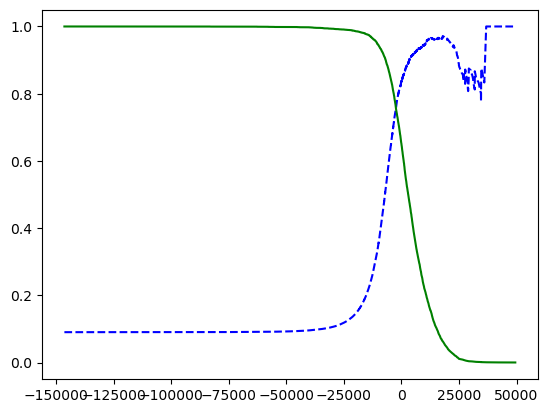

In [24]:
# 맷플롯립 이용해 임곗값의 함수로 정밀도와 재현율 그리기

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--',label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [25]:
# 정밀도 90%를 달성하는것이 목표라고해보자. 그래프에서 임곗값이 약3000정도일 때 달성되는것같다.
# 조금 더 정확한 임곗값을 찾아보자.
# np.argmax() 는 최대값의 첫 번째 인덱스를 반환한다. 여기에서는 첫 번째 True 값을 의미한다.

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.019499144183


In [26]:
# 훈련세트에 대한 예측을 만들려면 분류기의 predict() 메서드를 호출하는 대신 다음의 코드를 실행한다.

y_train_pred_90 = (y_scores >= threshold_90_precision)

# 이 예측에 대한 정밀도와 재현율 확인해보기

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

# 정밀도 0.9의 분류기 만들기 완성

0.9000345901072293
0.4799852425751706


## 3.3.5 ROC 곡선

수신기 조작 특성 (receiver operating characteristic) 곡선도 이진 분류에서 널리 사용되는 도구이다.

정밀도/재현율 곡선과 매우 비슷하지만 ROC 곡선은 정밀도에 대한 재현율 곡선이 아니고,

거짓양성비율(FPR = false positive rate) 에 대한 진짜양성비율(TNR = true negative rate: 재현율의 다른이름) 곡선이다.

* FPR : 양성으로 잘못 분류된 음성샘플의 비율 = 1 - TNR = 1 - 특이도

즉, ROC 곡선은 민감도(재현율)에 대한 1 - 특이도 그래프이다.

In [27]:
# ROC곡선을 그리기위해 먼저 roc_curve() 함수에서 여러 임곗값에서 TPR과 FPR 를 계산해야한다.

from sklearn.metrics import roc_curve

fpr,tpr, thresholds = roc_curve(y_train_5, y_scores)

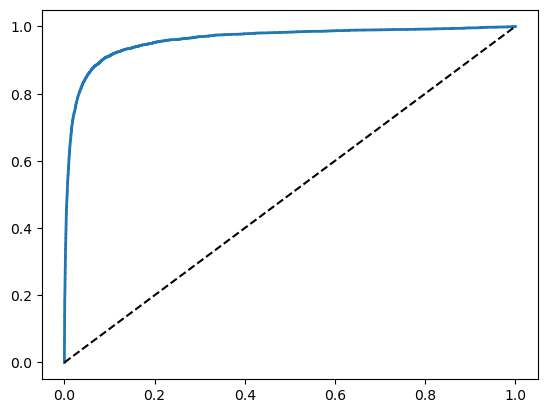

In [28]:
# 맷플롯립을 사용해 TPR 에 대한 FPR 곡선을 나타낼 수 있다.

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')   # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

# 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻한다.
# 좋은 분류기는 점선에서 최대한 멀리 떨어져야함 (왼쪽 위)

* AUC(area unter the curve = 곡선 아래 면적) 

 이를 측정하면 분류기들을 비교할 수 있다. 완벽한 분류기의 ROC의 AUC는 1이고, 완전한 랜덤 분류기는 0.5이다.

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* RandomForestClassifier과 비교
 
 SGDClassifier 의 ROC AUC 점수를 비교해보자.

 훈련 세트의 샘플에 대한 점수를 얻어야 하는데, RandomForestClassifier 에는 decision_function()  메서드가 없다.

 대신 predict_proba() 메서드가 존재.

 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환.

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv = 3,
                                    method="predict_proba")


In [31]:
# roc_curve() 함수는 레이블과 점수가 반환된다. 
# 점수 대신 클래스에 확률을 전달할 수 있다.
# 아래는 양성 클래스 확률을 점수로 사용하는 코드

y_scores_forest = y_probas_forest[:,1]   # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

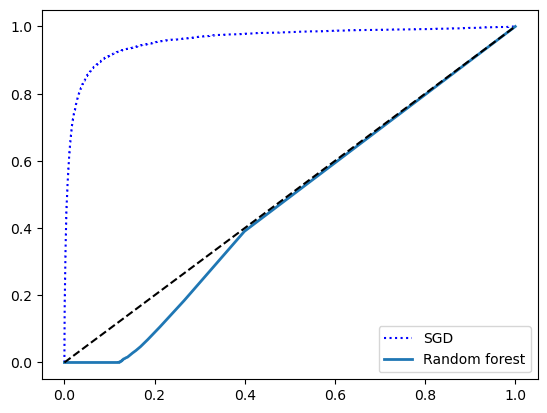

In [32]:
# 두 ROC 곡선을 동시에 그려 비교해보자

plt.plot(fpr,tpr,"b:", label = "SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random forest")
plt.legend(loc="lower right")
plt.show()

In [33]:
roc_auc_score(y_train_5,y_scores_forest)
# 뭔가이상함..

0.468152688230416

# 3.4 다중 분류

다중 분류기(multiclass classifier) 는 둘 이상의 클래스를 구별할 수 있다.

In [35]:
# OvO 전략을 사용하기위해 서포트 벡터 머신 분류기를 사용해보자.

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)   # y_train_5 가 아닌 y_train 을 사용한다.
svm_clf.predict([some_digit])


array([5], dtype=uint8)

In [36]:
# 45개의 이진 분류기를 통과하며 10개의 점수가 생긴다.
# decision_function() 메서드를 호출하면 샘플 당 10개의 점수를 반환한다. (클래스마다 하나씩)

some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

# 가장 높은 점수가 클래스 5에 해당하는 값이다.

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
np.argmax(some_digit_score)

5

In [38]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
svm_clf.classes_[5]

# 분류기 훈련 시 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장한다.
# 이 예시에서는 classes_ 배열에 있는 각 클래스의 인덱스가 클래스의 값 자체와 같다.

5

In [41]:
# 사이킷런에서 OvO 또는 OvR 을 사용하도록 강제하기 : OneVsOneClassifier 또는 OneVsRestVlassifier 사용
# 이진분류기 인스턴스를 만들어 객체 생성시 전달
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만드는 코드

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


array([5], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
# SGDClassifier 를 훈련시키는것도 간단하다.

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

# ? 틀렸는데

array([3], dtype=uint8)

In [45]:
# 클래스마다 부여한 점수를 살펴보자

sgd_clf.decision_function([some_digit])

# 뭔가 잘못됐다.

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
# 정확도를 평가해보자.

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

# 정확도 85% 이상인데 위 결과는 왜저러지?

array([0.87365, 0.85835, 0.8689 ])

In [47]:
# 입력의 스케일을 조정해 정확도를 높여보자

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# 89% 이상의 정확도를 만들어냈다.

array([0.8983, 0.891 , 0.9018])

# 3.5 에러 분석

만들어진 모델의 성능을 향상시키는 방법 중 하나는 만들어진 에러의 종류를 분석하는 것이다.

In [49]:
# 먼저 오차 행렬을 살펴보자. 
# cross_val_predict() 함수를 사용해 예측을 만들고 confusion_matrix() 함수를 호출한다.

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

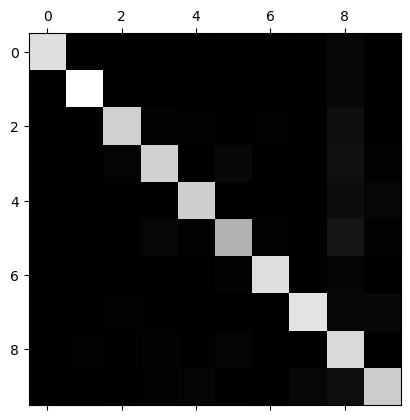

In [52]:
# 오차 행렬을 맷플롯립의 matshow() 함수를 사용해 이미지로 표현할 수 있다.

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# 대각원소들이 밝을수록 좋음.
# 숫자 5가 조금 어두워보인다. 
# 이는 데이터셋에 숫자5의 이미지가 적거나 분류기가 숫자5를 다른숫자만큼 구분을 잘 하지 못한다는 뜻.

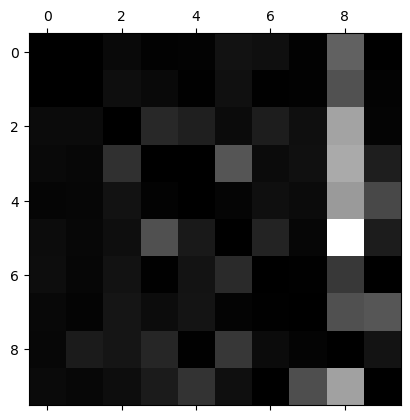

In [54]:
# 그래프의 에러 부분에 집중해보자.
# 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러비율을 비교

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# 다른 항목은 그대로 유지하고 대각원소만 0으로 채워 그래프를 그려보자

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# 행은 실제 클래스, 열은 예측 클래스

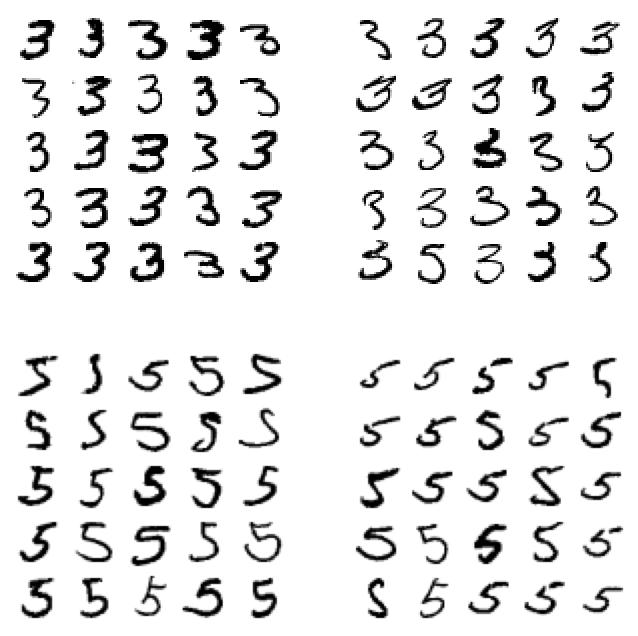

In [55]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()



# 3.6 다중 레이블 분류

각 샘플마다 여러개의 클래스를 출력해야 할 때도 있다.(하나의 샘플이 여러개의 클래스에 속함)

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]   # 각 숫자에 두 개의 타깃 레이블이 담긴 y_multilabel 만든다.

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# KNeighborsClassifier는 다중 레이블 분류를 지원한다.

knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:
# 위에서 만든 다중 레이블 분류기를 평가하기 위해 F1 score 를 계산한다.
# 프로젝트마다 적절한 평가지표가 다를 수 있다.
# 다음 코드는 모든 레이블에 대한 F1 score의 평균 점수를 계산한다.

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')   # average = 'weighted' 로 설정하면 타깃 레이블이 속한 샘플 수 (지지도)를 가중치로 준다.

0.976410265560605

# 3.7 다중 출력 분류

다중 출력 다중 클래스 분류(multioutput-multiclass classification)는 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것이다.

이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어보자.

잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배욜로 출력한다.

분류기의 출력이 다중레이블(픽셀당 한 레이블)이고 각 레이블은 여러개 가지므로(0부터255까지 픽셀 강도) 다중 출력 분류 시스템이다.

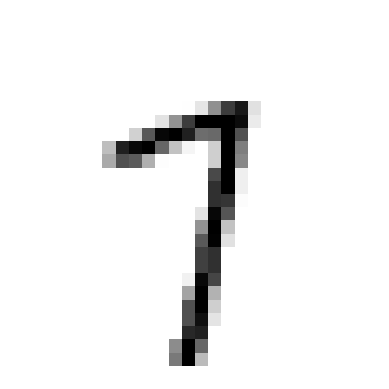

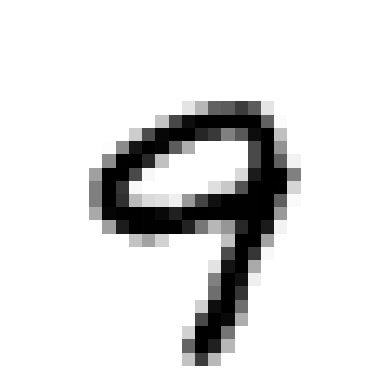

In [68]:
# MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 ranint() 함수를 사용해 픽셀 강도에 잡음 추가
# 타깃이미지는 원본 이미지

noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

other_digit = y_train_mod[42]
other_digit_image = other_digit.reshape(28,28)
plt.imshow(other_digit_image, cmap="binary")
plt.axis("off")
plt.show()

test_digit = y_test_mod[58]
test_digit_image = test_digit.reshape(28,28)
plt.imshow(test_digit_image, cmap="binary")
plt.axis("off")
plt.show()

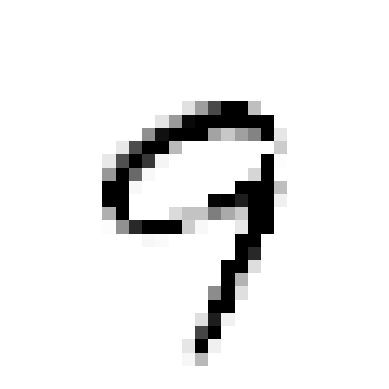

In [69]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[58]])
plot_digit(clean_digit)